# sentiment analysis model 

 Importing required libraries

In [1]:
# import
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set random seeds ensures that your experiments are reproducible
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True

set_seed()

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Exploration

In [ ]:
# Load and explore data
df = pd.read_csv('/content/balancedBIG.csv')
print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum()}")
print(f"Duplicate entries: {df.duplicated().sum()}")

Dataset shape: (99000, 3)
Missing values:
Text               0
Sentiment          0
Sentiment_Label    0
dtype: int64
Duplicate entries: 0


In [5]:
# Drop missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [6]:
# Check class distribution
print("\nClass distribution:")
class_counts = df['Sentiment_Label'].value_counts()
print(class_counts)


Class distribution:
Sentiment_Label
0    33000
2    33000
1    33000
Name: count, dtype: int64


<ipython-input-7-996bdcb14ca6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=df, palette='viridis')


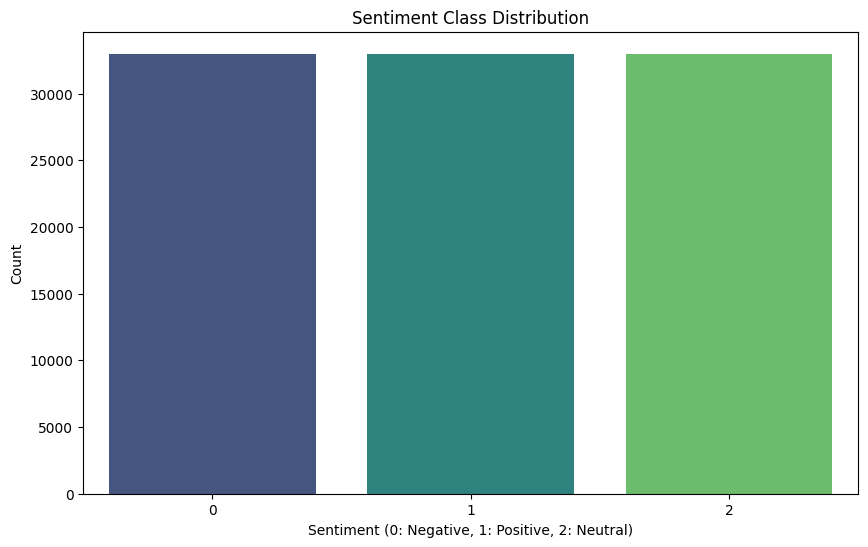

In [ ]:
# visualize Sentiment_Label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment_Label', data=df, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive, 2: Neutral)')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

In [ ]:
# text preprocessing and preparation
def clean_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, HTML tags, and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)

    # Remove special characters but keep emoticons
    text = re.sub(r'[^\w\s:;)(><]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text cleaning
df['cleaned_text'] = df['Text'].apply(clean_text)

In [9]:
df.head()

,Text,Sentiment,Sentiment_Label,cleaned_text
0,Not well suited for the Jawbone II: When I fir...,Negative,0,not well suited for the jawbone ii: when i fir...
1,I asked ChatGPT how to build the humidity &amp...,Negative,0,i asked chatgpt how to build the humidity amp;...
2,Okay i feel really sick now,Negative,0,okay i feel really sick now
3,I should be asleep trying to be...,Neutral,2,i should be asleep trying to be
4,Niggas are worried about the cost of the PS5 &...,Neutral,2,niggas are worried about the cost of the ps5 a...


In [10]:
# Display some cleaned examples
print("\nSample cleaned texts:")
for i in range(3):
    print(f"Original: {df['Text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")
    print(f"Sentiment: {df['Sentiment'].iloc[i]} ({df['Sentiment_Label'].iloc[i]})\n")


Sample cleaned texts:
Original: Not well suited for the Jawbone II: When I first installed one of these on my new Jawbone II, they were fantastic. They fit my ear canal perfectly, negating the need for the ear loop that came with it. Unfotunately after a few days they started rejecting my headset. The ear pieces would not stay on the Jawbone, and they would no longer stay firmly in my ear. I tried washing and drying them thoroughly, but that only helped for an hour or so. I am not sure what the fit problem is, but they turned out to not work for my Jawbone II and me at all.
Cleaned: not well suited for the jawbone ii: when i first installed one of these on my new jawbone ii they were fantastic they fit my ear canal perfectly negating the need for the ear loop that came with it unfotunately after a few days they started rejecting my headset the ear pieces would not stay on the jawbone and they would no longer stay firmly in my ear i tried washing and drying them thoroughly but that onl

# Prepare Data For The Modelling

In [ ]:
# Prepare data for training by extracting features
X = df['cleaned_text'].tolist()      # the cleaned text as input features
y = df['Sentiment_Label'].tolist()   # the sentiment labels as output labels

In [ ]:
# train_test_split (70-15-15)
# This splits the dataset into training, validation, and test sets to ensuring that each set has a balanced distribution of sentiment classe
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, stratify=y_train_val, random_state=42)

print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Training size: 69339
Validation size: 14811
Test size: 14850


Tokenization and Padding

In [ ]:
# Initialize better tokenizer - RoBERTa performs well for sentiment
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')   # Load the BERT tokenizer for text preprocessing

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Function to tokenize text data and prepare it for model training
def tokenize_and_prepare(texts, labels, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Create a PyTorch TensorDataset with input IDs, attention masks, and labels
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )

    return dataset   # Return the prepared dataset

In [ ]:
# Apply tokenize_and_prepare function on data
train_dataset = tokenize_and_prepare(X_train, y_train)
val_dataset = tokenize_and_prepare(X_val, y_val)
test_dataset = tokenize_and_prepare(X_test, y_test)

Data Loaders

In [ ]:
# Create DataLoaders for training, validation, fast Training and test datasets with specified batch sizes
batch_size = 32  # Set batch size for training
# DataLoader for training dataset (with shuffling to ensure randomness during training)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# DataLoader for validation dataset (no shuffling as validation should be deterministic)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
# DataLoader for test dataset (no shuffling)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Initializing BERT Model for Sentiment Classification

In [ ]:
# Initialize the BERT model for sequence classification with 3 output labels (sentiment classes: Negative, Neutral, Positive)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Pretrained BERT model (lowercase version)
    num_labels=3,         # Number of sentiment classes (3: Negative, Neutral, Positive)
    output_attentions=False,
    output_hidden_states=False,
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Fine-tuning hyperparameters for training the BERT model
learning_rate = 2e-5    # controls how much the model weights are updated during training.
weight_decay = 0.01     # prevent overfitting by penalizing large weights during training.
epochs = 10             # how many times the entire dataset will be passed through the model during training.

In [ ]:
# Create the AdamW optimizer with weight decay for model optimization
# Used to update the model's parameters during training
optimizer = AdamW(
    model.parameters(),        # Pass model parameters to be optimized
    lr=learning_rate,          # Set the learning rate for parameter updates
    weight_decay=weight_decay  # Apply weight decay to prevent overfitting by penalizing large weights
)


In [ ]:
# Create a learning rate scheduler to adjust the learning rate during training
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup

# Initialize the scheduler to decrease the learning rate linearly after warmup
scheduler = get_scheduler(
    name="linear",                   # Use a linear scheduler for learning rate decay
    optimizer=optimizer,             # The optimizer that the scheduler will adjust the learning rate for
    num_warmup_steps=warmup_steps,   # Number of steps for warming up the learning rate
    num_training_steps=total_steps   # Total number of steps for the entire training process
)

In [ ]:
# Move the model to device (GPU or CPU) for training
model.to(device)   # Transfers the model to the available device

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Model Training

Training and Validation Loop

In [ ]:
# Training loop with validation to train and evaluate the model over multiple epochs
best_val_accuracy = 0    # Track the best validation accuracy
best_model_state = None  # Store the best model's state

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for batch in progress_bar:
        # Get batch data
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            labels=batch_labels
        )

        loss = outputs.loss
        train_loss += loss.item()

        # Store predictions and labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch_labels.cpu().numpy())

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Calculate training metrics
    train_accuracy = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_mask,
                labels=batch_labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_labels.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")

Epoch 1/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 1/10:
Train Loss: 0.7990, Train Accuracy: 0.6306
Val Loss: 0.6171, Val Accuracy: 0.7422
New best model saved with validation accuracy: 0.7422


Epoch 2/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.13it/s]



Epoch 2/10:
Train Loss: 0.5184, Train Accuracy: 0.7910
Val Loss: 0.4700, Val Accuracy: 0.8156
New best model saved with validation accuracy: 0.8156


Epoch 3/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 3/10:
Train Loss: 0.3043, Train Accuracy: 0.8866
Val Loss: 0.4620, Val Accuracy: 0.8383
New best model saved with validation accuracy: 0.8383


Epoch 4/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 4/10:
Train Loss: 0.1858, Train Accuracy: 0.9320
Val Loss: 0.5528, Val Accuracy: 0.8357


Epoch 5/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 5/10:
Train Loss: 0.1249, Train Accuracy: 0.9569
Val Loss: 0.6032, Val Accuracy: 0.8450
New best model saved with validation accuracy: 0.8450


Epoch 6/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 6/10:
Train Loss: 0.0912, Train Accuracy: 0.9694
Val Loss: 0.7673, Val Accuracy: 0.8517
New best model saved with validation accuracy: 0.8517


Epoch 7/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 7/10:
Train Loss: 0.0639, Train Accuracy: 0.9806
Val Loss: 0.8631, Val Accuracy: 0.8530
New best model saved with validation accuracy: 0.8530


Epoch 8/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.12it/s]



Epoch 8/10:
Train Loss: 0.0476, Train Accuracy: 0.9866
Val Loss: 0.9598, Val Accuracy: 0.8534
New best model saved with validation accuracy: 0.8534


Epoch 9/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.13it/s]



Epoch 9/10:
Train Loss: 0.0306, Train Accuracy: 0.9917
Val Loss: 1.0434, Val Accuracy: 0.8546
New best model saved with validation accuracy: 0.8546


Epoch 10/10 [Validation]: 100%|██████████| 463/463 [01:30<00:00,  5.13it/s]


Epoch 10/10:
Train Loss: 0.0209, Train Accuracy: 0.9942
Val Loss: 1.0459, Val Accuracy: 0.8567
New best model saved with validation accuracy: 0.8567


final accuracy

In [23]:
# Load best model for evaluation
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_accuracy:.4f}")

Loaded best model with validation accuracy: 0.8567


# Evaluate the Model

In [ ]:
# Put the model in evaluation mode and make predictions on the test data
# Collect predictions and true labels to measure final performance
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch_labels.cpu().numpy())

Testing: 100%|██████████| 465/465 [01:31<00:00,  5.09it/s]


Calculate and Display Test Results

In [ ]:
# Calculate overall accuracy on the test set
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Print a detailed classification report (precision, recall, f1-score) for each sentiment class
print("\nClassification Report:")
report = classification_report(
    test_labels,
    test_preds,
    target_names=['Negative', 'Positive', 'Neutral'],
    digits=4
)
print(report)


Test Accuracy: 0.8537

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8822    0.8578    0.8698      4950
    Positive     0.8675    0.8768    0.8721      4950
     Neutral     0.8127    0.8265    0.8195      4950

    accuracy                         0.8537     14850
   macro avg     0.8541    0.8537    0.8538     14850
weighted avg     0.8541    0.8537    0.8538     14850



In [26]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[4246  192  512]
 [ 179 4340  431]
 [ 388  471 4091]]


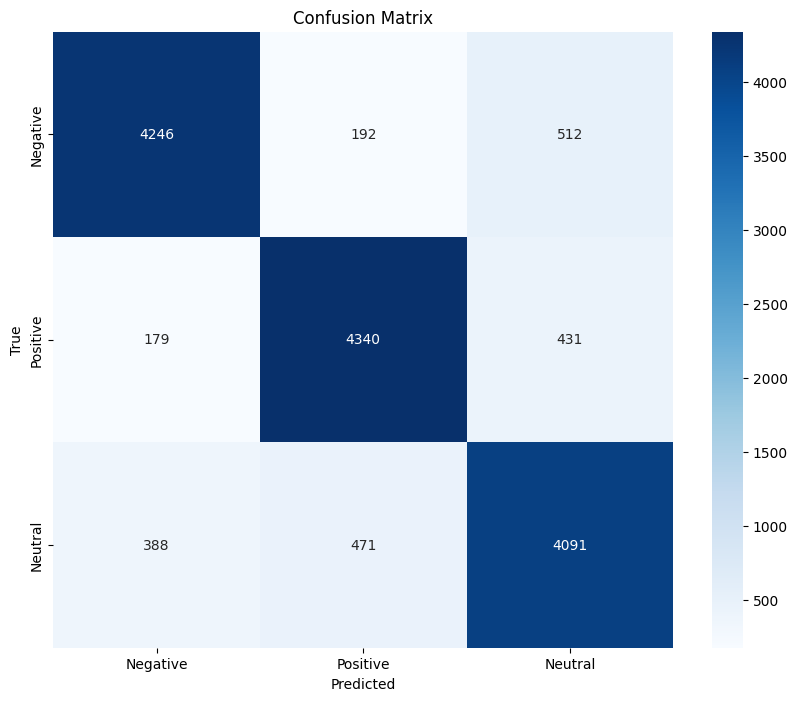

In [27]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive', 'Neutral'],
    yticklabels=['Negative', 'Positive', 'Neutral']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save The Model

In [28]:
# Save the model
model_save_path = 'bert_sentiment_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")


Model saved to bert_sentiment_model


In [ ]:
# MODEL SAVED

# Prediction using BERT

In [ ]:
# Function to predict sentiment for new text
def predict_sentiment(text, max_length=128):
    # Clean the text
    cleaned = clean_text(text)

    # Tokenize the cleaned text using the pre-trained tokenize
    inputs = tokenizer(
        cleaned,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=max_length
    ).to(device)         # Move inputs to the same device

    # Get prediction from the model
    model.eval()    # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)      # Forward pass through the model
        prediction = torch.argmax(outputs.logits, dim=1).item()   # Get the class with the highest score

    # Map the predicted class index to sentiment label
    sentiments = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    return sentiments[prediction]


In [ ]:
# Test the prediction function with some examples 
example_texts = [
    "I absolutely love this product! It's amazing.",
    "This is the worst experience I've ever had.",
    "The package arrived on time as expected."
]

print("\nExample predictions:")
for text in example_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment}\n")


Example predictions:
Text: I absolutely love this product! It's amazing.
Predicted sentiment: Positive

Text: This is the worst experience I've ever had.
Predicted sentiment: Negative

Text: The package arrived on time as expected.
Predicted sentiment: Positive

